In [1]:
import torch
torch.cuda.is_available()

device = torch.device('cpu')
if torch.cuda.is_available():
    # CUDA 사용 가능
    device = torch.device('cuda')
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    # Apple Silicon (MPS) 사용 가능
    device = torch.device('mps')
print("사용 장치:", device)

사용 장치: cuda


# CNN (Convolutional Neural Network)

In [2]:
import torch
# pytorch 에서 제공하는 cv 라이브러리
# 데이터 가져오기 , 모델, 이미지 변환
import torchvision
import torchvision.transforms as transforms

In [3]:
# 데이터셋에 적용할 변환
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616),)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:04<00:00, 40.7MB/s]


  cat   car   car truck


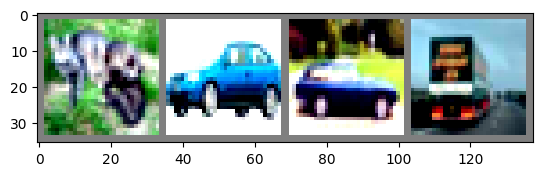

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 학습용 이미지를 무작위로 가져오기
sampleloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
dataiter = iter(sampleloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### DataLoader 생성

In [5]:
# 훈련용 로더
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
# 검증(테스트)용 로더
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

# CNN 학습하기

In [16]:
import torch.nn as nn

# 간단한 cnn 클래스
class SimpleCNN(nn.Module):
  def __init__(self, num_classes=10):
    # 상속받은 클래스의 생성자
    super().__init__()

    # 특징 추출
    # mlp에서 했었던 거 -> sequential (linear -> relu -> dropout -> linear -> relu -> dropout)
    self.features = nn.Sequential(
        # 첫번째 합성곱
        # 입력되고자 하는 이미지의 채널(in_channels - RGB) - 채널마다 16개의 특성 찾기 / padding 을 넣어야 3*3 이 다 돌아볼 수 잇다
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(), # 활성화 함수
        nn.MaxPool2d(kernel_size=2, stride=2), # 풀
        # 원래 이미지 : 32 * 32 -> 16 * 16 (풀 하면서 반토막남)
        # 가로 세로 절반


        # 두번째 합성곱
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )
    # 최종적으로 8*8 짜리 feature가 32개 생성


    # 분류 - mlp
    self.classifier = nn.Sequential(
        nn.Linear(in_features=32*8*8, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=256),
        nn.ReLU(),
        # 출력층의 out_features는
        nn.Linear(in_features=256, out_features=num_classes)
    )

  # 평탄화 작업 필요
  def forward(self, x):
    # 1. 특징 추출
    x = self.features(x)
    # 2. 32*8*8을 (32*8*8, 1) -> 벡터로
    x = torch.flatten(x, start_dim=1)
    # 3. 분류 시도
    x = self.classifier(x)
    return x

In [17]:
model = SimpleCNN(num_classes=10).to(device)

# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
from tqdm import tqdm

num_epochs = 10 # 10번 에포크 동안 학습

for epoch in range(num_epochs):
    # --- 훈련(Train) 단계 ---
    model.train() # 모델을 학습 모드로 설정
    running_loss = 0.0
    # 진행률 바 설정
    for i, data in enumerate(tqdm(trainloader), 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        # inputs, labels = data[0], data[1]

        # 1. 옵티마이저의 기울기를 0으로 초기화
        optimizer.zero_grad()

        # 2. 순전파(forward pass)
        outputs = model(inputs)
        # 3. 손실 계산
        loss = criterion(outputs, labels)
        # 4. 역전파(backward pass)
        loss.backward()
        # 5. 파라미터 업데이트
        optimizer.step()

        running_loss += loss.item()

    print(f'[{epoch + 1}] 훈련 손실: {running_loss / len(trainloader):.3f}')

    # --- 평가(Evaluation) 단계 ---
    model.eval() # 모델을 평가 모드로 설정
    correct = 0
    total = 0
    with torch.no_grad(): # 기울기 계산 비활성화
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'[{epoch + 1}] 테스트 정확도: {100 * correct / total:.2f} %')

print('학습 종료')

100%|██████████| 391/391 [00:12<00:00, 30.10it/s]


[1] 훈련 손실: 1.430
[1] 테스트 정확도: 57.75 %


100%|██████████| 391/391 [00:13<00:00, 28.65it/s]


[2] 훈련 손실: 1.048
[2] 테스트 정확도: 63.29 %


100%|██████████| 391/391 [00:13<00:00, 29.53it/s]


[3] 훈련 손실: 0.884
[3] 테스트 정확도: 68.18 %


100%|██████████| 391/391 [00:12<00:00, 30.25it/s]


[4] 훈련 손실: 0.764
[4] 테스트 정확도: 69.50 %


100%|██████████| 391/391 [00:13<00:00, 29.48it/s]


[5] 훈련 손실: 0.654
[5] 테스트 정확도: 70.22 %


100%|██████████| 391/391 [00:13<00:00, 30.08it/s]


[6] 훈련 손실: 0.555
[6] 테스트 정확도: 71.36 %


100%|██████████| 391/391 [00:12<00:00, 30.21it/s]


[7] 훈련 손실: 0.460
[7] 테스트 정확도: 71.43 %


100%|██████████| 391/391 [00:13<00:00, 29.69it/s]


[8] 훈련 손실: 0.370
[8] 테스트 정확도: 70.72 %


100%|██████████| 391/391 [00:13<00:00, 29.30it/s]


[9] 훈련 손실: 0.290
[9] 테스트 정확도: 70.65 %


100%|██████████| 391/391 [00:15<00:00, 25.73it/s]


[10] 훈련 손실: 0.231
[10] 테스트 정확도: 70.10 %
학습 종료


GroundTruth:   frog  ship  deer  frog


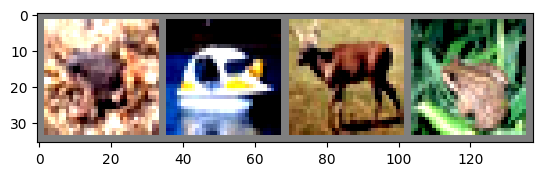

In [19]:
sampleloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)
dataiter = iter(sampleloader)
images, labels = next(dataiter)

# 이미지 출력
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [20]:
outputs = model(images.to(device))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  frog  bird  deer  cat  


In [22]:
from PIL import Image

image_file = 'cat.jpeg'
image = Image.open(image_file).convert('RGB')

# 훈련 시 사용했던 전처리 과정을 그대로 정의
inference_transform = transforms.Compose([
    transforms.Resize((32, 32)), # 1. 32x32 크기로 리사이즈
    transforms.ToTensor(),       # 2. 텐서로 변환
    # 3. 훈련 때와 "동일한" 값으로 정규화
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))
])

# 전처리 적용
input_tensor = inference_transform(image)

# 전처리 된 이미지 확인
print(input_tensor.shape) # torch.Size([3, 32, 32])

# 1. 모델을 평가 모드로 전환
model.eval()

# 2. 배치 차원 추가 및 장치로 이동
input_batch = input_tensor.unsqueeze(0).to(device)
# input_batch = input_tensor.unsqueeze(0)

# 3. 기울기 계산을 하지 않도록 설정
with torch.no_grad():
    output = model(input_batch)

# 4. 출력(Logits)을 확률(Probabilities)로 변환
# Softmax 함수는 모든 클래스에 대한 점수의 합이 1이 되도록 만듬
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# 5. 가장 확률이 높은 클래스 찾기
top_prob, top_catid = torch.max(probabilities, 0)
predicted_idx = top_catid.item()

# CIFAR-10 클래스 이름 가져오기
class_names = trainset.classes # ['airplane', 'automobile', 'bird', 'cat', ...]
predicted_label = class_names[predicted_idx]

print(f"모델의 예측: '{predicted_label}' (신뢰도: {top_prob.item()*100:.2f}%)")

torch.Size([3, 32, 32])
모델의 예측: 'cat' (신뢰도: 99.77%)
